In [1]:
# loading python modules
import numpy as np
from terminaltables import AsciiTable 

from __future__ import division

In [2]:
# loading custom inet modules
from inet import DataLoader
from inet.motifs import iicounter
from inet.utils import chem_squarematrix, elec_squarematrix

In [3]:
# use the dataset to create the null hypothesis
mydataset = DataLoader('../data')

 161 syn  files loaded


<H2>Collect number of experiments </H2>

In [4]:
# e.g. mydataset.PV[2].values  will return the different configurations with 2 PV cells
nPV = range(9)
for i in nPV:
    nPV[i] = np.sum(mydataset.PV[i].values())
    nPV[i] = np.sum(mydataset.PV[i].values())

In [5]:
nPV

[0, 141, 18, 2, 0, 0, 0, 0, 0]

In [6]:
# for the moment, we only count experiments with 2 or 3 PVs
# later we use mydataset.PV[2:]
PV2 = sum(mydataset.PV[2].values())
PV3 = sum(mydataset.PV[3].values())
PV2, PV3

(18, 2)

<H2> Calculate empirical probabilities </H2>

In [7]:
PC = mydataset.II_chem_found/mydataset.II_chem_tested
PE = mydataset.II_elec_found/mydataset.II_elec_tested
PCE1 = mydataset.II_ce1_found/mydataset.II_ce1_tested
PCE2 = mydataset.II_ce2_found/mydataset.II_ce2_tested

print('P(C)     : chemical synapse                       = %2.4f' %PC)
print('P(E)     : electrical synapse                     = %2.4f' %PE)
print('P(E U C) : electrical and unidirectional chemical = %2.4f' %PCE1)
print('P(E U 2C): electrical and bidirectional chemical  = %2.4f' %PCE2)

P(C)     : chemical synapse                       = 0.2917
P(E)     : electrical synapse                     = 0.4583
P(E U C) : electrical and unidirectional chemical = 0.1458
P(E U 2C): electrical and bidirectional chemical  = 0.1250


<H2> Simulate random chemical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.


In [8]:
def mychem_simulation():
    """
    simulate inhibitory chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(chem_squarematrix(size=2,prob = PC))

    for _ in range(PV3):
        mycount += iicounter(chem_squarematrix(size=3, prob = PC))
        
    return(mycount)

In [9]:
mychem_simulation() # one simulation, test the number of connection tested

{'ii_ce1': {'found': 0, 'tested': 48},
 'ii_ce2': {'found': 0, 'tested': 24},
 'ii_chem': {'found': 10, 'tested': 48},
 'ii_elec': {'found': 0, 'tested': 24}}

In [10]:
# must contain the same number of tested connections
for key in mychem_simulation().keys():
    print(key, mydataset.motif[key])

('ii_ce1', {'tested': 48, 'found': 7})
('ii_elec', {'tested': 24, 'found': 11})
('ii_ce2', {'tested': 24, 'found': 3})
('ii_chem', {'tested': 48, 'found': 14})


In [11]:
# simulate the whole data set 10,000 times
n_chem = list()
for _ in range(1000):
    syn_counter = mychem_simulation()
    n_chem.append(syn_counter['ii_chem']['found'])

If the null hypothesis is correctly implemented, we should see almost the same 
number of chemical synases as in the experiments.

In [12]:
np.mean(n_chem) # on average 14 connections


14.047000000000001

In [13]:
mydataset.motif['ii_chem']['found']

14

<H2> Simulate random electrical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.

In [14]:
def myelec_simulation():
    """
    simulate inhibitory electrical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(elec_squarematrix(size=2,prob = PE))

    for _ in range(PV3):
        mycount += iicounter(elec_squarematrix(size=3, prob = PE))
        
    return(mycount)

In [15]:
myelec_simulation() # one simulation, test the number of connection tested

{'ii_ce1': {'found': 0, 'tested': 48},
 'ii_ce2': {'found': 0, 'tested': 24},
 'ii_chem': {'found': 0, 'tested': 48},
 'ii_elec': {'found': 8, 'tested': 24}}

In [16]:
# must contain the same number of tested connections
for key in myelec_simulation().keys():
    print(key, mydataset.motif[key])

('ii_ce1', {'tested': 48, 'found': 7})
('ii_elec', {'tested': 24, 'found': 11})
('ii_ce2', {'tested': 24, 'found': 3})
('ii_chem', {'tested': 48, 'found': 14})


In [17]:
n_elec = list()
for _ in range(1000):
    syn_elec = myelec_simulation()
    n_elec.append(syn_elec['ii_elec']['found'])

Similarly, we must see almost the same 
number of electrical connections as with the experiments

In [18]:
np.mean(n_elec)

10.939

In [19]:
mydataset.motif['ii_elec']['found'] # voila!

11

<H2>Simulate electrical and chemical synapses independently</H2>

In [20]:
C = chem_squarematrix(size = 2, prob = PC)
E = elec_squarematrix(size = 2, prob = PE)
C + E # when a chemical (1) and electrical (2) synapse add , they have the motif 3

array([[0, 3],
       [0, 0]])

In [21]:
def myii_simulation():
    """
    simulate inhibitory electrical and chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        C = chem_squarematrix(size = 2, prob = PC)
        E = elec_squarematrix(size = 2, prob = PE)
        
        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    for _ in range(PV3):
        C = chem_squarematrix(size = 3, prob = PC)
        E = elec_squarematrix(size = 3, prob = PE)

        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    return(mycount)

In [22]:
myii_simulation()# one simulation, again, test the number of connections tested

{'ii_ce1': {'found': 8, 'tested': 48},
 'ii_ce2': {'found': 1, 'tested': 24},
 'ii_chem': {'found': 15, 'tested': 48},
 'ii_elec': {'found': 12, 'tested': 24}}

In [23]:
# must contain the same number of tested connections
for key in myii_simulation().keys():
    print(key, mydataset.motif[key])

('ii_ce1', {'tested': 48, 'found': 7})
('ii_elec', {'tested': 24, 'found': 11})
('ii_ce2', {'tested': 24, 'found': 3})
('ii_chem', {'tested': 48, 'found': 14})


In [24]:
# simulate the whole data set 1,000 times
n_chem = list()
n_elec = list()
n_ce1 = list()
n_ce2 = list()

for _ in range(1000):
    syn_counter = myii_simulation()
    n_chem.append( syn_counter['ii_chem']['found'] )
    n_elec.append( syn_counter['ii_elec']['found'] )
    n_ce1.append( syn_counter['ii_ce1']['found'] )
    n_ce2.append( syn_counter['ii_ce2']['found'] )

In [25]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical'], 
    ['chemical', np.mean(n_chem),  mydataset.motif['ii_chem']['found']],
    ['electrical', np.mean(n_elec),  mydataset.motif['ii_elec']['found']],
    ['1 chem + elec', np.mean(n_ce1),  mydataset.motif['ii_ce1']['found']],
    ['2 chem + elec', np.mean(n_ce2),  mydataset.motif['ii_ce2']['found']],
     ]
print(AsciiTable(info).table)

+---------------+-------------+-----------+
| Syn Motif     | Simulations | Empirical |
+---------------+-------------+-----------+
| chemical      | 14.018      | 14        |
| electrical    | 10.993      | 11        |
| 1 chem + elec | 6.463       | 7         |
| 2 chem + elec | 0.944       | 3         |
+---------------+-------------+-----------+


Let's see if the connections found correspond to the theoretical values for the complex motifs. 


<H3>ce1: unidirectional chemical connections in the presence of an electrical synapse</H3>

In [26]:
mydataset.motif['ii_ce1']

{'found': 7, 'tested': 48}

In [27]:
PCE1 = mydataset.motif['ii_ce1']['found']/mydataset.motif['ii_ce1']['tested']
PCE1

0.14583333333333334

In [28]:
(PC*PE)*mydataset.motif['ii_ce1']['tested'] # this value must be close to the simulation

6.416666666666666

<H3>ce2: bidirectional chemical connections in the presence of an electrical synapse</H3>

In [29]:
mydataset.motif['ii_ce2']

{'found': 3, 'tested': 24}

In [30]:
PCE2 = mydataset.motif['ii_ce2']['found']/mydataset.motif['ii_ce2']['tested']
PCE2

0.125

In [31]:
(PE*PC*PC)*mydataset.motif['ii_ce2']['tested'] # this value must be close to the simulation

0.9357638888888891

<H2>Calculating P-Values</H2>

In [32]:
n_chem = np.array(n_chem)
n_elec = np.array(n_elec)
n_ce1 = np.array(n_ce1)
n_ce2 = np.array(n_ce2)


In [33]:
pii_chem = len(n_chem[n_chem>mydataset.motif['ii_chem']['found']])/len(n_chem)
pii_elec = len(n_elec[n_elec>mydataset.motif['ii_elec']['found']])/len(n_elec)
pii_ce1 = len(n_ce1[n_ce1>mydataset.motif['ii_ce1']['found']])/len(n_ce1)
pii_ce2 = len(n_ce2[n_ce2>mydataset.motif['ii_ce2']['found']])/len(n_ce2)


In [34]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical', 'P(Simulations)'], 
    ['chemical', np.mean(n_chem),  mydataset.motif['ii_chem']['found'], pii_chem],
    ['electrical', np.mean(n_elec),  mydataset.motif['ii_elec']['found'], pii_elec],
    ['1 chem + elec', np.mean(n_ce1),  mydataset.motif['ii_ce1']['found'], pii_ce1],
    ['2 chem + elec', np.mean(n_ce2),  mydataset.motif['ii_ce2']['found'], pii_ce2],
     ]
print(AsciiTable(info).table)

+---------------+-------------+-----------+----------------+
| Syn Motif     | Simulations | Empirical | P(Simulations) |
+---------------+-------------+-----------+----------------+
| chemical      | 14.018      | 14        | 0.414          |
| electrical    | 10.993      | 11        | 0.437          |
| 1 chem + elec | 6.463       | 7         | 0.314          |
| 2 chem + elec | 0.944       | 3         | 0.012          |
+---------------+-------------+-----------+----------------+


In [35]:
from inet.plots import barplot

<H2> Plot chemical synapses alone</H2>

P = 0.4140


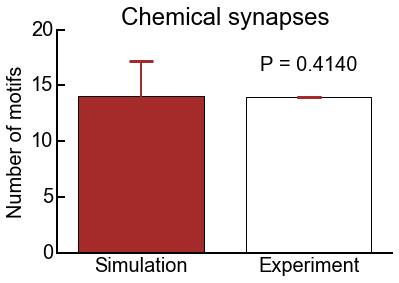

In [36]:

ax = barplot(simulation = n_chem, n_found = mydataset.motif['ii_chem']['found']);
ax.set_title('Chemical synapses');
ax.set_ylim(ymax=20);

<H2>Plot electrical synapses alone </H2>

P = 0.4370


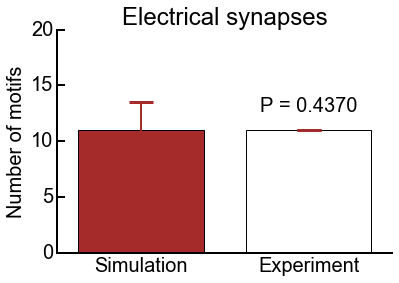

In [37]:
ax = barplot(simulation = n_elec, n_found = mydataset.motif['ii_elec']['found']);
ax.set_title('Electrical synapses');
ax.set_ylim(ymax=20);

<H2>Plot electrical and one chemical synapse alone </H2>

P = 0.3140


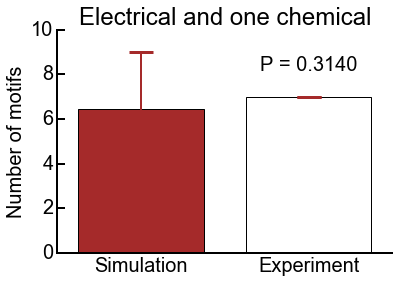

In [40]:
ax = barplot(simulation = n_ce1, n_found = mydataset.motif['ii_ce1']['found']);
ax.set_title('Electrical and one chemical');
ax.set_ylim(ymax=10);

<H2>Plot electrical and two chemical</H2>

P = 0.0120


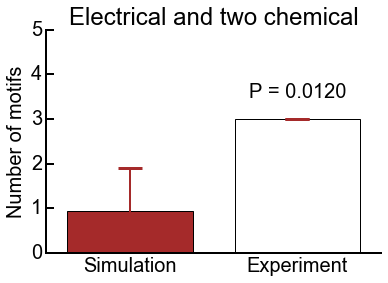

In [44]:
ax = barplot(simulation = n_ce2, n_found = mydataset.motif['ii_ce2']['found']);
ax.set_title('Electrical and two chemical');
ax.set_ylim(ymin  = 0, ymax=5);